In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import copy
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
sys.path.append(parent_dir)

# Regular Imports
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from tqdm import tqdm

import matplotlib.pyplot as plt

# Gaussian Free Field (GFF)

Create position space samples $\{[\phi(x)]_i\}_{i}$ from the distribution
$$
p(\phi) = \frac{e^{-\beta S[\phi]}}{Z}, \text{ s.t. } S[\phi] = \int d^d x ~\phi(x) (D_x + m^2) \phi(x)
$$
where the field has been descrtized to the lattice $\phi : [0, ..., 1]^d \to \mathbb R$

In [3]:
from inference.distribution import Sampleable
from abc import ABC, abstractmethod

class FreeFieldTheory(Sampleable, ABC):
    '''
    Free Field Theory assuming periodic boundary conditions.
    '''

    def __init__(self, 
                 lattice_points: int,
                 spacetime_dim: int,
                 device = "cuda" if torch.cuda.is_available() else "cpu"):
        '''
        Args:
            lattice_points: number of lattice points in theory
            dim: number of space dimensions
        '''
        self.lattice_points = lattice_points
        self.spacetime_dim = spacetime_dim
        self.device = device

    @abstractmethod
    def power_spectrum(self, k: torch.Tensor) -> torch.Tensor:
        '''
        Form of power spectrum

        Args:
        - k (torch.Tensor): Shape (power(lattice_points, spacetime_dim))

        Returns
        - Power spectrum evalulated at different k's. Shape (power(lattice_points, spacetime_dim))
        '''
        pass

    @property
    def dim(self) -> int:
        return self.lattice_points ** self.spacetime_dim

    def sample(self, num_samples: int) -> torch.Tensor:
        '''
        Gaussian Free Fields are uniquely defined by their two-point function.
        Hence we can construct a power spectrum, add noise, and inverse fourier transform it;
        this generates position-space configuration of the associated field.

        Args:
            - num_samples (int): The desired number of samples.
        Returns:
            - samples: Shape (batch_size, power(lattice_points, spacetime_dim)).
        '''
        N = self.lattice_points
        d = self.spacetime_dim
        shape = (N,) * d

        # Create frequency meshgrid: k_i in [-π, π]
        k_axes = [torch.fft.fftfreq(N, d=1.0).to(self.device) * 2 * torch.pi for _ in range(d)]
        k_mesh = torch.meshgrid(*k_axes, indexing='ij')

        # Compute P(k)
        Pk = self.power_spectrum(k=k_mesh)  # Shape: (N,...,N)

        # Complex Gaussian noise: (batch_size, *shape)
        noise_real = torch.randn((num_samples, *shape), device=self.device)
        noise_imag = torch.randn((num_samples, *shape), device=self.device)
        eta_k = torch.complex(noise_real, noise_imag)

        # Multiply by sqrt(P(k)) and apply inverse FFT
        phi_k = eta_k * torch.sqrt(Pk)
        phi_x = torch.fft.ifftn(phi_k, dim=tuple(range(1, d + 1))).real

        return phi_x

Shape of samples torch.Size([5, 128, 128])


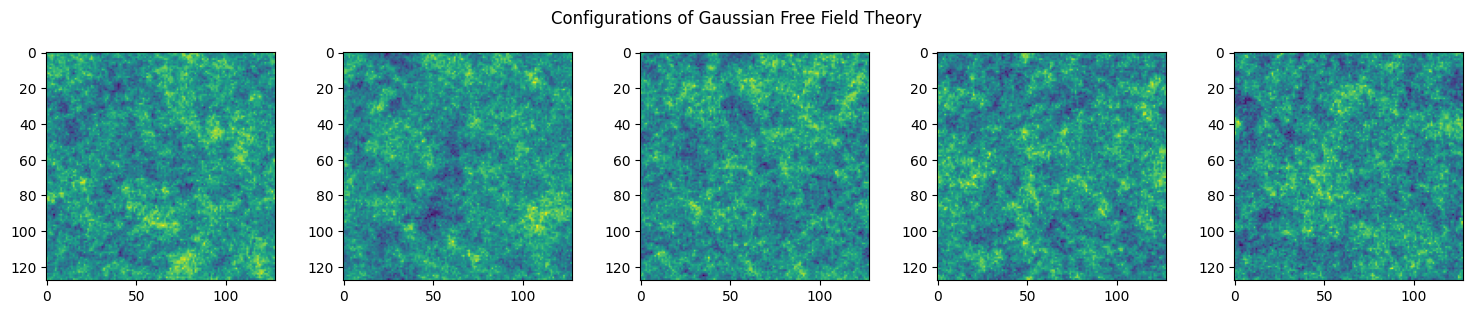

In [4]:
class ExampleGaussianFreeField(FreeFieldTheory):

    def power_spectrum(self, k: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - k (torch.Tensor): Shape (power(lattice_points, spacetime_dim))

        Returns
        - Power spectrum evalulated at different k's. Shape (power(lattice_points, spacetime_dim))
        """
        k_squared = sum((2 * torch.sin(ki / 2))**2 for ki in k)
        return 1.0 / (k_squared + 0.1**2)
    
# Generate Samples of Corresponding Field Theory
dist = ExampleGaussianFreeField(lattice_points=128, spacetime_dim=2)
samples = dist.sample(num_samples = 5)
print('Shape of samples', samples.shape)

# Visualize results
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, phi_config in enumerate(samples[:5]):
    axes[i].imshow(phi_config.cpu().detach().numpy())

plt.suptitle('Configurations of Gaussian Free Field Theory')
plt.tight_layout()
plt.show()


While this is very cute, we want samples from a $\phi^4$ theory. So we can use the corresponding GFF theory (that is $\lambda = 0$), and then transport the samples via Hamiltonian Monte Carlo

# $\phi^4$ Theory

We'll now construct position space samples from the distribution
$$
p(\phi) = \frac{e^{-\beta S[\phi]}}{Z}, \text{ s.t. } S[\phi] = \int d^d x ~\phi (D_x + m^2) \phi + \frac{\lambda}{4!} \phi^4
$$

In [7]:
from fieldtheory import FieldTheory

class Phi4(FieldTheory):

    def __init__(self, 
                 coupling: float = 0.01, 
                 kinetic_coupling: float = 0.3,
                 device = "cuda" if torch.cuda.is_available() else "cpu",
                 dtype = None):
        '''
        Implements 2D Phi4 Theory with periodic boundary conditions
        '''
        super().__init__(spacetime_dim=2, device=device)
        self.k = torch.tensor(kinetic_coupling, device=device, dtype=dtype)
        self.l = torch.tensor(coupling, device=device, dtype=dtype)

    def action(self, phi):
        k = self.k
        l = self.l
        return torch.sum(-2 * k * phi * (torch.roll(phi, 1, -1) + torch.roll(phi, 1, -2))
                    + (1 - 2 * l) * phi**2 
                    + l * phi**4, dim=(1,2))

    def _hmc_drift(self, phi):
        k = self.k
        l = self.l
        return (2 * k * (torch.roll(phi, 1, -1) + torch.roll(phi, -1, -1) + torch.roll(phi, 1, -2) + torch.roll(phi, -1, -2))
                + 2 * phi * (2 * l * (1 - phi**2) - 1))

/scratch/cm6627/flows/experiments/fieldtheory/fieldtheory.py:54: SyntaxWarning: invalid escape sequence '\_'
  def _hmc_drift(self, phi: torch.Tensor) -> torch.Tensor:


# Generate Samples
## Prebake

In [11]:
### Parameters
# Sampler Settings
batch_size = 1024
num_iterations = 1000

# Theory Parameters
lattice_points = 32
coupling = 0.02
kinetic_coupling = 0.3

### Run
phi_0 = torch.rand(size=(batch_size, lattice_points, lattice_points), device=device)
dist = Phi4(coupling=coupling, kinetic_coupling=kinetic_coupling)

for i in tqdm(range(num_iterations)):
    phi_0, new_S, accept_mask = dist.sample(phi_0=phi_0, n_steps=100)

100%|██████████| 1000/1000 [00:39<00:00, 25.51it/s]


## Generate Samples

In [14]:
# Generate more samples
cfgs = []

for i in tqdm(range(10000)):
    phi_0, S, accepted = dist.sample(phi_0=phi_0, n_steps=100)
    
    if i % 10 == 0: # Save every `iter` steps
        cfgs.append(copy.deepcopy(phi_0))

cfgs = torch.cat(cfgs)

# Naming convention
coupling_str = f"{coupling:.2f}".replace(".", "p")
kinetic_coupling_str = f"{kinetic_coupling:.2f}".replace(".", "p")
torch.save(cfgs, f'phi4_coupling{coupling_str}_kinetic{kinetic_coupling_str}.pt')

print('all done!')

100%|██████████| 10000/10000 [06:32<00:00, 25.46it/s]


I'll note that it was actually quite difficult to trasport samples from $\lambda = 0 \to \lambda \neq 0$ distributions... I thought HMC would move them super quickly...